The Synthetic Employee Records Dataset is a simulated dataset created to explore various data analysis and machine learning techniques in the context of human resources and employee management. This synthetic dataset mirrors the structure and characteristics of real employee data, while all the information contained within is entirely fictional and generated for illustrative purposes.

# TL;DR
* **Employee Tenure is the Strongest Predictor of Turnover:** The analysis reveals a clear and significant relationship between how long an employee has been with the company and their likelihood of leaving.
    * **Newer employees are at a much higher risk of leaving.** Specifically, employees with less than one year of tenure have a 100% turnover rate in this dataset.
    * The risk decreases as tenure increases. After just 30 days, an employee's odds of leaving decrease by about 14%.
    * This suggests that retention efforts should be heavily focused on the onboarding and early employment period.

* **Performance is Not a Major Factor in Turnover:** Surprisingly, an employee's performance score was not a significant predictor of whether they would leave the company. This means that both high and low performers are leaving at similar rates.

* **A Predictive Model Can Identify At-Risk Employees:** A logistic regression model was built that can predict the probability of an employee leaving with high accuracy (86% accuracy and an AUC of 0.95).
    * This model can be used to create a "risk score" for each employee, allowing HR and managers to proactively intervene with those at high risk of turnover.
    * The model identifies that a small percentage of current employees (about 5%) are in the "High Risk" category for turnover.

# Recommendations for Action:

* **Focus on Early-Career Retention:** Implement and enhance programs aimed at supporting new hires during their first year. This could include mentorship programs, more frequent check-ins, and clear career pathing discussions.
* **Don't Assume High Performers Will Stay:** Since performance isn't a key factor in turnover, it's crucial to have retention strategies for all employees, including top talent.
* **Utilize the Predictive Model:**
    * **For HR:** Use the model's risk scores to prioritize retention efforts and allocate resources effectively.
    * **For Managers:** Provide managers with insights into which of their team members are at a high risk of leaving, so they can have targeted conversations and offer support.
* **Investigate Other Potential Factors:** While tenure is the most significant predictor in this dataset, it would be beneficial to explore other potential drivers of turnover, such as compensation, work-life balance, and manager effectiveness, to get a more complete picture.

In [1]:
# Load packages and data
import time
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# load from psql db
from sqlalchemy import create_engine, text

# Database connection parameters
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_HOST = "localhost" 
DB_PORT = "5432"
DB_NAME = "people_analytics"

In [3]:
def create_db_connection():
    """Create a database connection with retry logic."""
    connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    
    max_retries = 5
    retry_delay = 2
    
    for attempt in range(max_retries):
        try:
            print(f"Attempting to connect to database (attempt {attempt + 1}/{max_retries})...")
            engine = create_engine(connection_string)
            # Test the connection
            with engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("Successfully connected to database!")
            return engine
        except Exception as e:
            print(f"Connection failed: {e}")
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Max retries reached. Unable to connect to database.")
                raise

In [4]:
import pandas as pd

def load_employee_data():
    """Load employee data from the database with specified dtypes."""
    engine = create_db_connection()
    query = "SELECT * FROM public.mrt_employee_360;"

    # Define the data types for each column based on the SQL schema
    employee_dtypes = {
        "employee_id": pd.Int32Dtype(),
        "first_name": pd.StringDtype(),
        "last_name": pd.StringDtype(),
        "email": pd.StringDtype(),
        "job_title": pd.StringDtype(),
        "business_unit": pd.StringDtype(),
        "department_type": pd.StringDtype(),
        "division": pd.StringDtype(),
        "state": pd.StringDtype(),
        "supervisor_name": pd.StringDtype(),
        "employee_status": pd.StringDtype(),
        "employee_type": pd.StringDtype(),
        "pay_zone": pd.StringDtype(),
        "classification_type": pd.StringDtype(),
        "termination_type": pd.StringDtype(),
        "termination_description": pd.StringDtype(),
        "performance_score": pd.StringDtype(),
        "current_rating": pd.Int32Dtype(),
        "gender": pd.StringDtype(),
        "race_ethnicity": pd.StringDtype(),
        "marital_status": pd.StringDtype(),
        "age": pd.Int32Dtype(),
        "tenure_days": pd.Int32Dtype(),
        "tenure_years": pd.Int32Dtype(),
        "tenure_bucket": pd.StringDtype(),
        "is_turnover": pd.BooleanDtype(),
        "hire_year": pd.Int32Dtype(),
        "hire_quarter": pd.Int32Dtype(),
        "performance_score_numeric": pd.Int32Dtype(),
        "is_high_performer": pd.Int32Dtype(),
        "is_low_performer": pd.Int32Dtype(),
        "engagement_score": pd.Int32Dtype(),
        "satisfaction_score": pd.Int32Dtype(),
        "work_life_balance_score": pd.Int32Dtype(),
        "overall_wellbeing_score": "float64",
        "engagement_level": pd.StringDtype(),
        "satisfaction_level": pd.StringDtype(),
        "work_life_balance_level": pd.StringDtype(),
        "engagement_risk_score": pd.Int32Dtype(),
        "engagement_risk_level": pd.StringDtype(),
        "total_trainings": pd.Int64Dtype(),
        "total_training_days": pd.Int64Dtype(),
        "total_training_cost": "float64",
        "training_success_rate": "float64",
        "technical_trainings": pd.Int64Dtype(),
        "leadership_trainings": pd.Int64Dtype(),
        "days_since_last_training": pd.Int32Dtype()
    }

    with engine.connect() as conn:
        df = pd.read_sql(query, conn, dtype=employee_dtypes)
    
    return df

In [5]:
df = load_employee_data()
df.info()

Attempting to connect to database (attempt 1/5)...
Successfully connected to database!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   employee_id                3000 non-null   Int32  
 1   first_name                 3000 non-null   string 
 2   last_name                  3000 non-null   string 
 3   email                      3000 non-null   string 
 4   job_title                  3000 non-null   string 
 5   business_unit              3000 non-null   string 
 6   department_type            3000 non-null   string 
 7   division                   3000 non-null   string 
 8   state                      3000 non-null   string 
 9   supervisor_name            3000 non-null   string 
 10  employee_status            3000 non-null   string 
 11  employee_type              3000 non-null   string 
 12  pay_zone         

In [6]:
df.head(1).transpose()

,0
employee_id,3984
first_name,Christine
last_name,Skinner
email,christine.skinner@bilearner.com
job_title,Database Administrator
business_unit,EW
department_type,IT/IS
division,Wireline Construction
state,TX
supervisor_name,Thomas Ramirez


In [7]:
df.head(50)[["tenure_days", "tenure_years"]]

,tenure_days,tenure_years
0,118,0
1,10,0
2,1004,2
3,1702,4
4,1099,3
5,1072,2
6,347,0
7,284,0
8,254,0
9,503,1


# Step 1: Data Preparation with Pandas

In [8]:
# Check the distribution of the Turnover variable
turnover_summary = df['is_turnover'].value_counts(normalize=True).mul(100).round(1).reset_index()
turnover_summary.columns = ['Turnover', 'percentage']
print("\nTurnover distribution:")
print(turnover_summary)


Turnover distribution:
   Turnover  percentage
0      True        51.1
1     False        48.9


In [9]:
# Summary statistics for tenure
print("\nTenure summary statistics:")
print(df['tenure_days'].describe())


Tenure summary statistics:
count         3000.0
mean     1044.685667
std       738.176971
min              0.0
25%            383.0
50%            955.5
75%           1621.0
max           2549.0
Name: tenure_days, dtype: Float64


In [10]:
# Check the distribution
tenure_cat_summary = df['tenure_bucket'].value_counts(normalize=True).mul(100).round(1).reset_index()
tenure_cat_summary.columns = ['tenure_bucket', 'percentage']
print("\nTenure bucket distribution:")
print(tenure_cat_summary)

# Check age distribution
print("\nAge summary statistics:")
print(df['age'].describe())


Tenure bucket distribution:
  tenure_bucket  percentage
0      3+ years        43.8
1     1-3 years        32.1
2     0-1 years        24.1

Age summary statistics:
count       3000.0
mean     53.388333
std      17.689144
min           24.0
25%           37.0
50%           53.0
75%           69.0
max           83.0
Name: age, dtype: Float64


# Step 2: Exploratory Analysis

In [11]:
# Overall turnover rate
overall_turnover_rate = df['is_turnover'].mean() * 100
print(f"Overall Turnover Rate: {overall_turnover_rate:.2f}%")

Overall Turnover Rate: 51.10%


In [12]:
# Turnover by performance score - potential predictor
performance_turnover = df.groupby('performance_score')['is_turnover'].agg(['count', 'mean']).rename(columns={'mean': 'turnover_rate'})
performance_turnover['turnover_rate'] = (performance_turnover['turnover_rate'] * 100).round(2)
print("\nTurnover by Performance Score:")
print(performance_turnover.sort_values('turnover_rate', ascending=False))


Turnover by Performance Score:
                   count  turnover_rate
performance_score                      
PIP                   93          52.69
Exceeds              369          51.76
Needs Improvement    177          51.41
Fully Meets         2361          50.91


In [13]:
# Turnover by tenure bucket
tenure_turnover = df.groupby('tenure_bucket')['is_turnover'].agg(['count', 'mean']).rename(columns={'mean': 'turnover_rate'})
tenure_turnover['turnover_rate'] = (tenure_turnover['turnover_rate'] * 100).round(2)
print("\nTurnover by Tenure Category:")
print(tenure_turnover)


Turnover by Tenure Category:
               count  turnover_rate
tenure_bucket                      
0-1 years        724          100.0
1-3 years        963          67.91
3+ years        1313          11.81


In [14]:
# Turnover by employee type - fairly even
etype_turnover = df.groupby('employee_type')['is_turnover'].agg(['count', 'mean']).rename(columns={'mean': 'turnover_rate'})
etype_turnover['turnover_rate'] = (etype_turnover['turnover_rate'] * 100).round(2)
print("\nTurnover by Employee Type:")
print(etype_turnover)


Turnover by Employee Type:
               count  turnover_rate
employee_type                      
Contract        1008          50.99
Full-Time       1038          51.45
Part-Time        954          50.84


In [15]:
is_turnover_int = df['is_turnover'].astype(int)  # Convert boolean to int for modeling

# Step 3: Model Building

In [16]:
# Use simple logistic regression to model turnover based on tenure
model_tenure = smf.logit('is_turnover_int ~ tenure_days', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.283831
         Iterations 8


In [17]:
# Get summary with coefficients
print(model_tenure.summary())

                           Logit Regression Results                           
Dep. Variable:        is_turnover_int   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2998
Method:                           MLE   Df Model:                            1
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.5904
Time:                        13:13:08   Log-Likelihood:                -851.49
converged:                       True   LL-Null:                       -2078.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7706      0.182     26.176      0.000       4.413       5.128
tenure_days    -0.0048      0.000    -26.850      0.000      -0.005      -0.004


In [18]:
# Get odds ratios and confidence intervals
params = model_tenure.params
conf = model_tenure.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print("\nOdds Ratios:")
print(np.exp(conf))


Odds Ratios:
                  2.5%       97.5%          OR
Intercept    82.548016  168.644860  117.988553
tenure_days   0.994900    0.995593    0.995246


In [19]:
# Interpretation
odds_ratio_day = np.exp(params['tenure_days'])
print(f"\nEach additional day of tenure reduces turnover odds by a factor of {odds_ratio_day:.3f}.")
print(f"This is a {(odds_ratio_day - 1) * 100:.1f}% reduction in odds per day.")


Each additional day of tenure reduces turnover odds by a factor of 0.995.
This is a -0.5% reduction in odds per day.


In [20]:
# More meaningful interpretation (per 30 days)
odds_ratio_30days = odds_ratio_day ** 30
print(f"\nAfter 30 days, an employee's odds of leaving are {odds_ratio_30days:.3f} of the original.")
print(f"This corresponds to a {(odds_ratio_30days - 1) * 100:.1f}% decrease in odds.")


After 30 days, an employee's odds of leaving are 0.867 of the original.
This corresponds to a -13.3% decrease in odds.


## About the output

* `z` in the summary is the z-score; a negative value indicates that as tenure increases, the log-odds of turnover decrease.
* The odds ratio (`OR`) for `Tenure_Days` is the exponentiated coefficient (`exp(coef)`). Here it's 0.995.
* Interpretation of the odds ratio (0.995) = for each additional day an employee works, their odds of turnover decrease by being multiplied by 0.995.

## Example of output

**After 1 day**
* (0.995 - 1) * 100 = -0.5
* Each day of working reduces turnover odds by 0.5%.
  
**After 30 days**
* 0.995^30 = 0.861
* After 30 days, an employee's odds of leaving are 86.1% of the original (a 13.9% decrease).

**Day 1 vs. Day 30**
* Day 1: A new employee has some baseline odds of leaving, let's say 2:1 odds = 67% probability of leaving.
* Day 31: That same employee now has odds that are 13.9% lower after 30 days: 2 × 0.861 = 1.72:1 odds = 63% probability of leaving.

## Scientific writeup
Tenure was significantly associated with turnover (β = -0.005, SE = 0.0002, p < 0.001). The odds ratio of 0.995 (95% CI [0.995, 0.996]) indicates that each additional day of tenure reduces turnover odds by 0.5%.

# Step 4: Multivariate Model Building

In [21]:
formula_mult = 'is_turnover_int ~ tenure_days + performance_score_numeric + age + current_rating + is_high_performer + engagement_score + satisfaction_score + work_life_balance_score'
model_mult = smf.logit(formula=formula_mult, data=df).fit()
print(model_mult.summary())

Optimization terminated successfully.
         Current function value: 0.283077
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        is_turnover_int   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2991
Method:                           MLE   Df Model:                            8
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.5915
Time:                        13:13:11   Log-Likelihood:                -849.23
converged:                       True   LL-Null:                       -2078.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.9707      0.461     10.774      0.000       4.

In [22]:
# Get results (odds ratios)
params_mult = model_mult.params
conf_mult = model_mult.conf_int()
conf_mult['OR'] = params_mult
conf_mult['p-value'] = model_mult.pvalues
conf_mult.columns = ['2.5%', '97.5%', 'OR', 'p-value']
odds_ratios_mult = np.exp(conf_mult)

print("\nMultivariate Model Odds Ratios:")
print(odds_ratios_mult.sort_values(by='p-value'))
# Looks like tenure days and performance score are the only significant predictors.


Multivariate Model Odds Ratios:
                                2.5%       97.5%          OR   p-value
Intercept                  58.345355  356.003819  144.122064  1.000000
tenure_days                 0.994887    0.995582    0.995234  1.000000
work_life_balance_score     0.844505    1.001400    0.919613  1.055362
satisfaction_score          0.894631    1.062711    0.975056  1.759809
engagement_score            0.941062    1.114881    1.024291  1.783977
is_high_performer           0.697632    1.700830    1.089290  2.027435
performance_score_numeric   0.856140    1.224500    1.023886  2.216576
age                         0.993676    1.007387    1.000508  2.421648
current_rating              0.824640    1.193094    0.991904  2.537673


In [23]:
# Create tenure + performance model
formula_perf = 'is_turnover_int ~ tenure_days + performance_score_numeric'
model_perf = smf.logit(formula=formula_perf, data=df).fit()

# Get its results
print("\nPerformance Model Summary:")
print(model_perf.summary())

# Compare model fit statistics (AIC, BIC)
model_comparison = pd.DataFrame({
    'Model': ['Tenure Only', 'Tenure + Performance', 'Full Model'],
    'AIC': [model_tenure.aic, model_perf.aic, model_mult.aic],
    'BIC': [model_tenure.bic, model_perf.bic, model_mult.bic]
})
print("\nModel Fit Comparison:")
print(model_comparison)
# Lower AIC and BIC indicate a better fit relative to model complexity.
# The tenure + performance model has a slightly lower AIC/BIC than tenure only.

Optimization terminated successfully.
         Current function value: 0.283822
         Iterations 8

Performance Model Summary:
                           Logit Regression Results                           
Dep. Variable:        is_turnover_int   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2997
Method:                           MLE   Df Model:                            2
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.5904
Time:                        13:13:13   Log-Likelihood:                -851.47
converged:                       True   LL-Null:                       -2078.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.7289      0.254   

## Test of Model Comparison

Here we are testing if the performance model (performance + tenure as predictors) fits the data significantly better than the tenure model (tenure as the only predictor). This is a Likelihood Ratio Test.

The null hypothesis (H0) is that the smaller model (tenure_continuous) is correct, meaning adding the performance score variable does not significantly improve model fit.

**Option 1**

If the result is significant (p-value < 0.05), we REJECT the null hypothesis. This means the larger model is a significant improvement, and we should include the performance score variable.

**Option 2**

If the result is non-significant (p-value >= 0.05), we FAIL TO REJECT the null hypothesis. This means the added complexity is not justified by the improvement in fit, and we should stick with the simpler (tenure only) model.

In [24]:
# In Python, we can perform a likelihood ratio test manually.
lr_stat = 2 * (model_perf.llf - model_tenure.llf)
df_diff = model_perf.df_model - model_tenure.df_model
p_value = stats.chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-value: {p_value:.4f}")

# The result is non-significant (p = 0.2016), so we continue with the simpler tenure model.

Likelihood Ratio Test Statistic: 0.0549
Degrees of Freedom: 1.0
P-value: 0.8147


# Step 5: Predictions and Insights

In [25]:
# Add predicted probabilities from the simple tenure model
df['predicted_prob'] = model_tenure.predict(df)
df['predicted_class'] = (df['predicted_prob'] > 0.5).astype(int)

# Distribution of predicted probabilities
print("Distribution of Predicted Probabilities:")
print(df['predicted_prob'].describe())

Distribution of Predicted Probabilities:
count    3000.000000
mean        0.511000
std         0.402151
min         0.000626
25%         0.049578
50%         0.554211
75%         0.950056
max         0.991596
Name: predicted_prob, dtype: float64


In [26]:
# Create a confusion matrix
# Note: The order is (Actual, Predicted)
conf_matrix = confusion_matrix(df['is_turnover'], df['predicted_class'])
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate classification accuracy
accuracy = accuracy_score(df['is_turnover'], df['predicted_class'])
print(f"\nClassification Accuracy: {accuracy:.4f}")
# Interpretation: When we use a 0.50 threshold, the model is correct about 86% of the time.


Confusion Matrix:
[[1232  235]
 [ 193 1340]]

Classification Accuracy: 0.8573


In [27]:
# Create risk categories
conditions = [
    df['predicted_prob'] >= 0.7,
    df['predicted_prob'] >= 0.3
]
choices = ['High Risk', 'Medium Risk']
df['risk_cat'] = np.select(conditions, choices, default='Low Risk')

# Summary by risk level for current employees
risk_summary = df[df['is_turnover'] == 0]['risk_cat'].value_counts(normalize=True).mul(100).round(1)
print("\nRisk Category Summary for Current Employees:")
print(risk_summary)


Risk Category Summary for Current Employees:
risk_cat
Low Risk       73.9
Medium Risk    20.9
High Risk       5.2
Name: proportion, dtype: float64


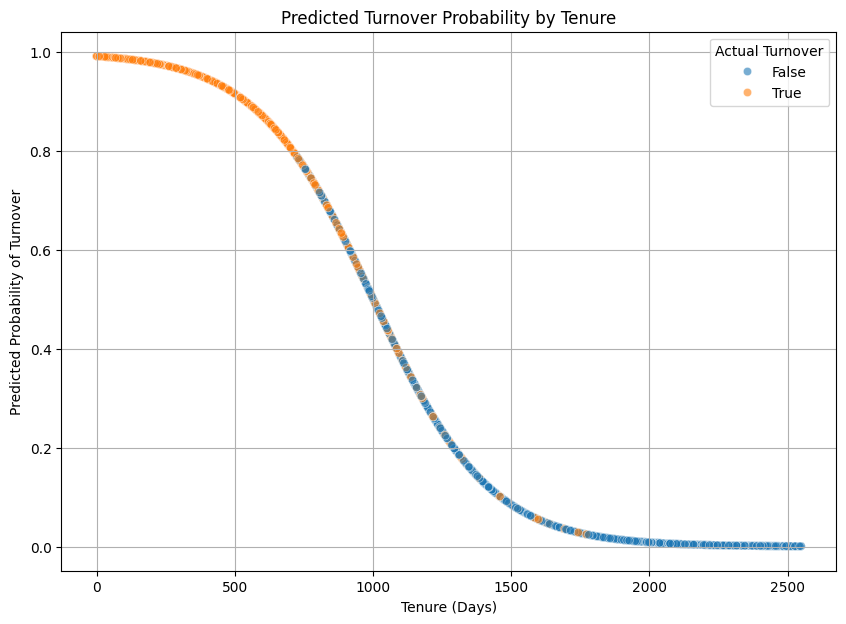

In [28]:
# Plotting with Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tenure_days', y='predicted_prob', hue='is_turnover', alpha=0.6)

plt.title('Predicted Turnover Probability by Tenure')
plt.xlabel('Tenure (Days)')
plt.ylabel('Predicted Probability of Turnover')
plt.legend(title='Actual Turnover')
plt.grid(True)
plt.show()

## ROC Curve Analysis

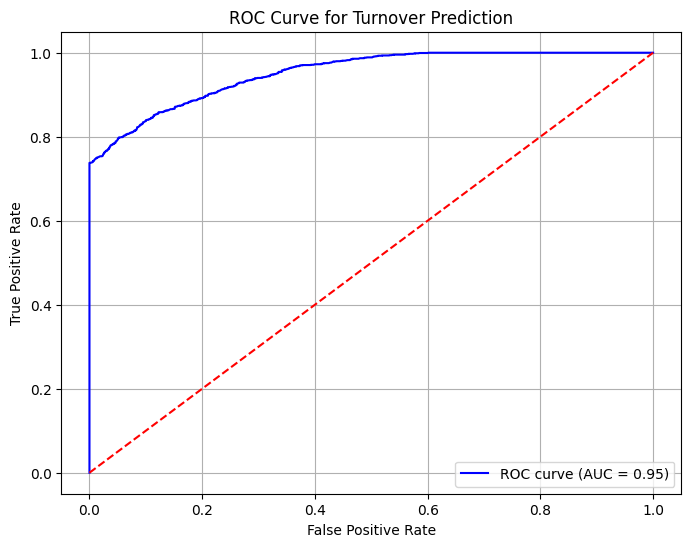

AUC Score: 0.9509


In [28]:
# ROC Curve Analysis
fpr, tpr, thresholds = roc_curve(df['is_turnover'], df['predicted_prob'])
auc_score = roc_auc_score(df['is_turnover'], df['predicted_prob'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Turnover Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC Score: {auc_score:.4f}")
# AUC = 0.5, model is no better than random guessing
# AUC = 1.0, perfect discrimination (model never makes mistakes in predicting turnover)
# An AUC of 0.95 means that if you randomly pick one employee who stayed and one who left,
# there's a 95% chance the model will correctly assign a higher turnover probability to the one who actually left.

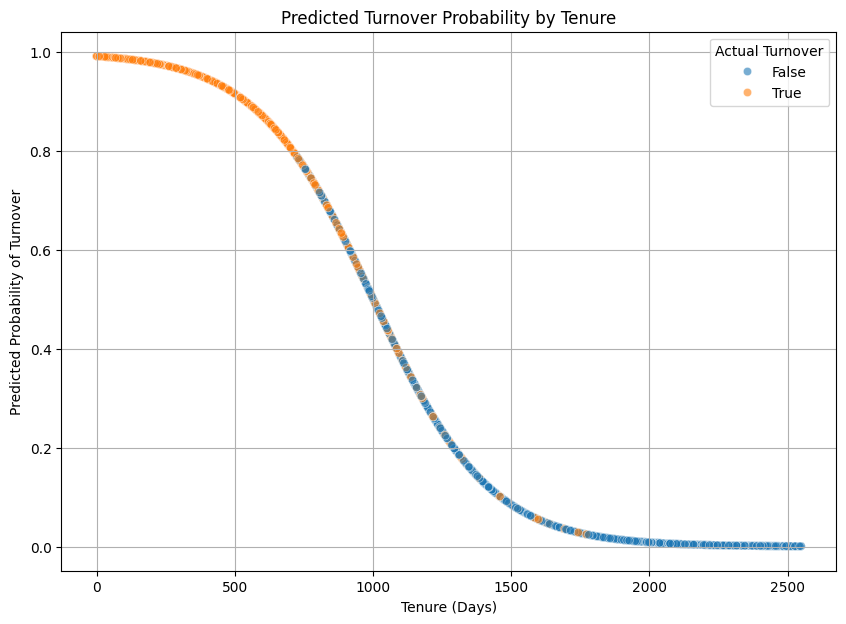

In [29]:
# Plotting with Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tenure_days', y='predicted_prob', hue='is_turnover', alpha=0.6)

plt.title('Predicted Turnover Probability by Tenure')
plt.xlabel('Tenure (Days)')
plt.ylabel('Predicted Probability of Turnover')
plt.legend(title='Actual Turnover')
plt.grid(True)
plt.show()